In [48]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [121]:
df=pd.read_csv('Fama_Macbeth.csv')
df.drop(columns='RF',inplace=True)
df.head()

,Time,Mkt-RF,SMB,HML,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
0,199001,-7.85,-1.30,0.81,-8.2806,-7.5898,-4.6359,-6.9495,-6.0635,-9.6130,...,-6.9905,-5.8085,-7.7701,-9.0236,-9.9589,-7.6055,-5.7797,-7.0677,-7.2541,-5.7852
1,199002,1.11,1.02,0.63,2.0056,2.0672,1.1292,3.4667,1.5431,3.4469,...,1.5972,1.4677,1.5451,1.5279,3.5218,-0.1106,1.8414,2.4739,1.3788,2.0042
2,199003,1.83,1.52,-2.91,4.4160,2.7600,2.2757,3.7239,1.4118,4.9281,...,3.8881,3.8489,1.8306,1.9770,-0.1681,3.9453,3.8505,0.1720,0.6526,1.0406
3,199004,-3.36,-0.51,-2.52,-2.5548,-2.3595,-1.7714,-2.4815,-3.5279,-4.0709,...,-2.8886,-4.1178,-6.2997,-5.2026,-5.9564,0.4673,-1.3318,-3.8571,-4.1127,-4.2175
4,199005,8.42,-2.54,-3.75,8.1103,6.2534,6.0564,4.2900,3.4223,10.7061,...,10.8332,8.5609,10.3263,7.1977,8.6740,11.5903,10.9442,7.5458,6.3937,7.8755


In [154]:
data=df.melt(id_vars=['Time','Mkt-RF','SMB','HML'],var_name='Portfolio',value_name='Ri')
data.sort_values(['Portfolio','Time'],inplace=True)
data.reset_index(inplace=True,drop=True)

In [155]:
data.head()

,Time,Mkt-RF,SMB,HML,Portfolio,Ri
0,199001,-7.85,-1.30,0.81,BIG HiBM,-5.7852
1,199002,1.11,1.02,0.63,BIG HiBM,2.0042
2,199003,1.83,1.52,-2.91,BIG HiBM,1.0406
3,199004,-3.36,-0.51,-2.52,BIG HiBM,-4.2175
4,199005,8.42,-2.54,-3.75,BIG HiBM,7.8755


In [156]:
all_betas=[]
    
# rolling 5期
for i,group in data.groupby('Portfolio'):
    beta_list=[]
    rolling_list=[]
    for rolling in group.rolling(5):      
        rolling_list.append(rolling)
    rolling_list=rolling_list[4:]
    for rolling in rolling_list:
        y=rolling['Ri'].to_numpy()
        x=rolling[['Mkt-RF','SMB','HML']].to_numpy()
        model=sm.OLS(y,x).fit()
        beta_list.append(model.params[0])
    all_betas.append(beta_list)

In [157]:
all_betas=np.array(all_betas)
all_betas=all_betas.transpose()

In [158]:
mean=all_betas.mean(axis=0)
std=all_betas.std(axis=0)
t_stat=mean/std
t_stat

array([2.52962045, 3.64088099, 2.75504378, 2.87609408, 2.64068115,
       2.99171576, 3.91270035, 3.84921741, 3.25053568, 3.51168736,
       2.48698891, 2.83694117, 3.45786479, 3.18427107, 3.39873968,
       3.09047785, 2.98110575, 3.01666284, 2.38274904, 2.60987331,
       3.64344746, 2.8243261 , 3.1181103 , 2.37647644, 1.77398106])

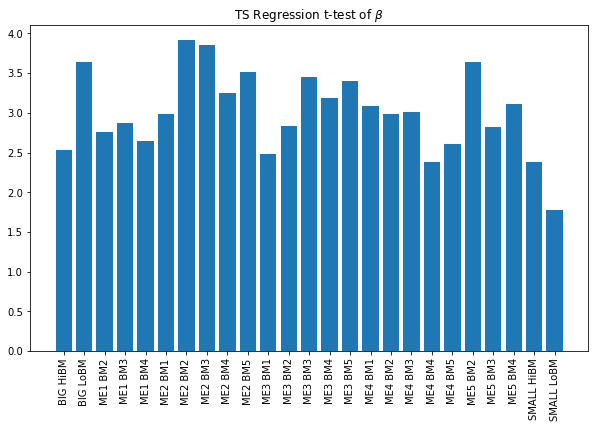

In [194]:
fig,ax=plt.subplots(figsize=[10,6])
ax.bar(data['Portfolio'].unique(),t_stat)
plt.title(fr'TS Regression t-test of $\beta$')
plt.xticks(rotation=90)
plt.show()

In [160]:
time=data[data['Time']>=199005]['Time'].unique().reshape(-1,1)
all_betas=np.concatenate([time,all_betas],axis=1)

In [129]:
portfolio=data.Portfolio.unique()
columns=np.insert(portfolio,0,'Time',axis=0)
all_betas=pd.DataFrame(all_betas,columns=columns)
all_betas=all_betas.melt(id_vars='Time',var_name='Portfolio',value_name='Beta')

In [130]:
all_betas

,Time,Portfolio,Beta
0,199005.0,BIG HiBM,0.926229
1,199006.0,BIG HiBM,1.068474
2,199007.0,BIG HiBM,1.010862
3,199008.0,BIG HiBM,1.005232
4,199009.0,BIG HiBM,0.938874
...,...,...,...
8320,201709.0,SMALL LoBM,0.717563
8321,201710.0,SMALL LoBM,0.961428
8322,201711.0,SMALL LoBM,0.904070
8323,201712.0,SMALL LoBM,0.880867


In [131]:
value_vars=df.columns[4:]
data=df.melt(id_vars='Time',value_vars=value_vars,var_name='Portfolio',value_name='Ri').sort_values('Time')
data.reset_index(inplace=True,drop=True)

In [132]:
new_data=pd.merge(data,all_betas,on=['Time','Portfolio'])
new_data.sort_values(['Time','Portfolio'],inplace=True)
new_data.reset_index(inplace=True,drop=True)

In [133]:
new_data.head()

,Time,Portfolio,Ri,Beta
0,199005,BIG HiBM,7.8755,0.926229
1,199005,BIG LoBM,11.5903,0.840666
2,199005,ME1 BM2,6.2534,0.840934
3,199005,ME1 BM3,6.0564,0.610168
4,199005,ME1 BM4,4.2900,0.736835


In [134]:
factor_list=[]
for i,group in new_data.groupby('Time'):
    y=group['Ri'].to_numpy()
    x=group['Beta'].to_numpy()
    model=sm.OLS(y,x).fit()
    factor_list.append(model.params[0])

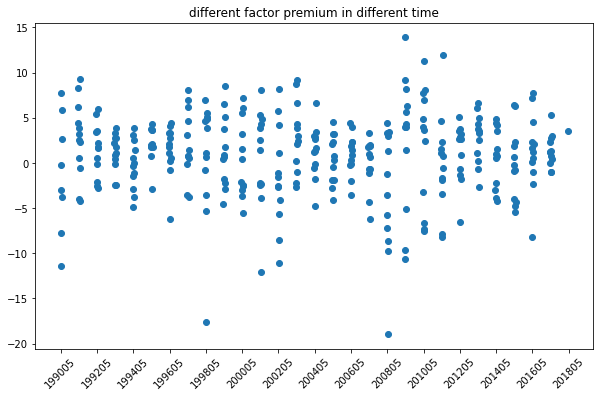

In [190]:
time=time.reshape(-1)
fig,ax=plt.subplots(figsize=[10,6])
ax.scatter(time,factor_list)
plt.title(fr'different factor premium in different time')
plt.xticks(np.arange(199005,201812,200),rotation=45)
plt.show()

In [31]:
mean=np.mean(factor_list)
std=np.std(factor_list)
t_stat=(mean-0)/std
print(t_stat)

0.2068249350985934
